In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load Data

In [27]:
def load_data():
    tr = pd.read_csv('./data/train.csv')
    va = pd.read_csv('./data/valid.csv')
    ts = pd.read_csv('./data/test.csv')
    
    return tr, va, ts

def write_predictions(file_name, va, pred):
    data = {
        "review_id": va.review_id.tolist(),
        "stars": pred
    }
    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False)

In [4]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
stopwords_lst = set(stopwords.words("english"))
ps = PorterStemmer()


def preprocess(text, MAX_LEN):
    """
    param: pd.Series of raw text
    return: preprocessed sentences
    """
    output = []
    for sentence in text:
        tokenized_text = tokenizer.tokenize(sentence)
        # stemmed_text = [ps.stem(token).lower() for token in tokenized_text]
#         tokenized_text = [w for w in tokenized_text if w not in stopwords_lst]
        if len(tokenized_text) > (MAX_LEN-2):
            output.append(["[CLS]"] + tokenized_text[0:128] + tokenized_text[-(MAX_LEN-130):] + ["[SEP]"])
        else:
            output.append(["[CLS]"] + tokenized_text + ["[SEP]"])

        
    return output

In [5]:
def get_input_ids(text , MAX_LEN):
    tokenized_texts = preprocess(text, MAX_LEN)

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    
    return input_ids

In [6]:
def get_dataloader(input_ids, labels, batch_size):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
        
    inputs = torch.tensor(input_ids)
    labels = torch.tensor(labels)
    masks = torch.tensor(attention_masks)
    
    data = TensorDataset(inputs, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    
    return dataloader

In [7]:
tr, va, ts = load_data()

MAX_LEN = 256

train_input_ids = get_input_ids(tr.text, MAX_LEN)
val_input_ids = get_input_ids(va.text, MAX_LEN)

train_labels = tr.stars.tolist()
val_labels = va.stars.tolist()


batch_size = 10
train_dataloader = get_dataloader(train_input_ids, train_labels, batch_size)
validation_dataloader = get_dataloader(val_input_ids, val_labels, batch_size)

In [8]:
# specify GPU device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [9]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", cache_dir='./pretrained_model', num_labels=6)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [10]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
val_loss_set = []
train_accu_set = []
val_accu_set = []
# Number of training epochs 
epochs = 3

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
    ## TRAINING
  
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_tr_accuracy = flat_accuracy(logits, label_ids)
#         train_accu_set.append(tmp_tr_accuracy)
        tr_accuracy += tmp_tr_accuracy
        
        nb_tr_steps += 1
        

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss_set.append(tr_loss/nb_tr_steps)
    print("Train accuracy: {}".format(tr_accuracy/nb_tr_steps))
    train_accu_set.append(tr_accuracy/nb_tr_steps)
    
    
    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         val_loss_set.append(loss.item())
        eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
#         val_accu_set.append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_steps += 1
    
    print("Validation loss: {}".format(eval_loss/nb_eval_steps))
    val_loss_set.append(eval_loss/nb_eval_steps)
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    val_accu_set.append(eval_accuracy/nb_eval_steps)
    print("==============================================")

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.8162636948600411
Train accuracy: 0.6555000000000006


Epoch:  50%|█████     | 1/2 [15:48<15:48, 948.71s/it]

Validation loss: 0.7271539641171694
Validation Accuracy: 0.6810000000000003
Train loss: 0.5683503005038947
Train accuracy: 0.7634000000000006


Epoch: 100%|██████████| 2/2 [31:38<00:00, 949.07s/it]

Validation loss: 0.7950851444527507
Validation Accuracy: 0.6884999999999998


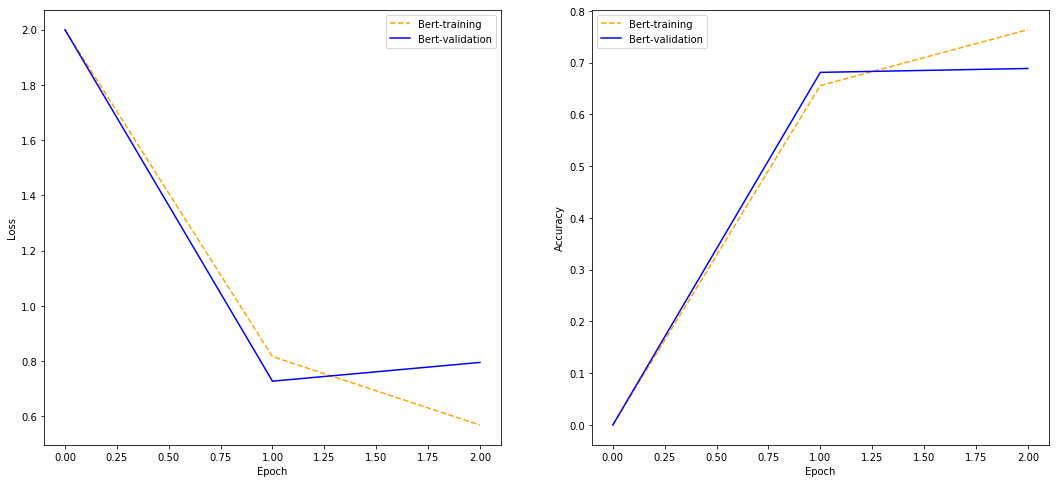

In [11]:
# plot training process
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot([2] + train_loss_set, label="Bert-training", color="orange", linestyle="dashed")
plt.plot([2] + val_loss_set, label="Bert-validation", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot([0] + train_accu_set, label="Bert-training", color="orange", linestyle="dashed")
plt.plot([0] + val_accu_set, label="Bert-validation", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [34]:
# ts_input_ids = get_input_ids(ts.text, MAX_LEN)

# ts_labels = ts.stars.tolist()

prediction_dataloader = get_dataloader(val_input_ids, ts_labels, batch_size)

## Prediction on val set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions= []
# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    # Store predictions and true labels
    predictions.append(logits)
    
    
# Flatten the predictions
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [35]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

acc = accuracy_score(flat_predictions, val_labels)
p, r, f1, _ = precision_recall_fscore_support(flat_predictions, val_labels, average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.6885 	precision: 0.5972567549738317 	recall: 0.6173645325254181 	f1: 0.587137109523603


In [33]:
write_predictions("data/pred_bert.csv", va, flat_predictions)

# Notes for training

1. default setting, without stopwords, full tr, MAX_LEN = 256, batch_size=8, epochs = 15 (overfitting after 6) ---- val accuracy: 62.25% (on 6th ephoch - 65.05%)
2. default setting, without stopwords, tr 4000, MAX_LEN = 512, batch_size=4, epochs = 8 (overfitting) ---- val accuracy: 61.00% (on 6th ephoch - 62.8%)
3. default setting, with stopwords, tr 2000, MAX_LEN = 512, batch_size=4, epochs = 8 (overfitting) ---- val accuracy: 60.75% (on 2th ephoch - 65%)
4. default setting, with stopwords, tr 2000, MAX_LEN = 512(top128+tail382), batch_size=4, epochs = 8 (overfitting) ---- val accuracy: 65% (on 2th epoch - 66.7%)
5. default setting, with stopwords, tr 4000, MAX_LEN = 512(top128+tail382), batch_size=4, epochs = 6 (overfitting) ---- val accuracy: 66.9% 
6. default setting, with stopwords, tr 4000, MAX_LEN = 256(top128+tail126), batch_size=8, epochs = 6  ---- 2nd epoch val accuracy: 67.15% 
7. default setting, with stopwords, tr 4000, MAX_LEN = 256(top128+tail126), batch_size=10, epochs = 6  ---- 2nd epoch val accuracy: 68.35% 
8. default setting, with stopwords, tr 4000, MAX_LEN = 256(top64+tail190), batch_size=10, epochs = 6  ---- 3nd epoch val accuracy: 63% 
9. default setting, without stopwords, tr 4000, MAX_LEN = 256(top128+tail126), batch_size=10, epochs = 6  ---- 2nd epoch val accuracy: 63.5% 
10. default setting, with stopwords, full tr, MAX_LEN = 256(top128+tail126), batch_size=10, epochs = 6 (overfitting after 2) ---- 2th ephoch val accuracy - 69.5%)

In [29]:
pred_val_bert = pd.read_csv("data/pred_val_bert.csv")

In [30]:
pred_val_bert

,review_id,stars
0,ewaMkuxfjfCX3ndtk0oRTw,3
1,SzkuvIpf0lcVaDgk5x2ipg,5
2,ZGg6emL3sqhyyqHD_DJEag,5
3,IXYLmBVvRVFJZEhnhE_YsQ,5
4,dao7SEXhBuMk7TieM4gEZA,3
...,...,...
1995,auJ3tOHWVN593s48gMEZAA,1
1996,z8_kPnWkBsITTY7CjcIZQQ,5
1997,xqo9xCZgK2Ws0tcRcJltJg,4
1998,tKb2ykTDFsJoFDYTOElaVA,1
